In [1]:
!pip install scanpy
!pip install KDEpy
!pip install leidenalg

Looking in indexes: https://pypi.org/simple, https://pypi.ngc.nvidia.com
Looking in indexes: https://pypi.org/simple, https://pypi.ngc.nvidia.com
Looking in indexes: https://pypi.org/simple, https://pypi.ngc.nvidia.com


# Analysis of clusters in sample S3

In [2]:
import pandas as pd
import scanpy as sc
import anndata as ad
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import scipy.sparse as sps
from scipy.stats import ranksums, spearmanr, kendalltau

import os
import sys
module_path = os.path.abspath(os.path.join('../..'))
if module_path not in sys.path:
    sys.path.append(module_path)
    
import tools.util_probe as up
import tools.util as ut
import tools.NB_est as nb
import tools.countsplit as cs
import tools.ClusterDE as cd

import importlib

## Preprocessing
### Read data

In [3]:
data_path = "../../data/BacDrop"
data_gene = sc.read_h5ad(data_path + "/klebsiella_4species_data_processed.h5ad")


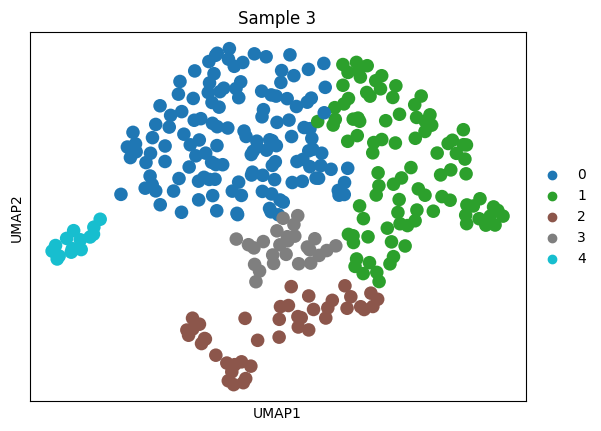

In [4]:
sc.pl.umap(data_gene, color="leiden_opt", palette="tab10", title="Sample 3")
plt.show()

## Generate synthetic null data for ClusterDE

### Estimate distribution and parameters for every gene

In [5]:
importlib.reload(nb)
import warnings
warnings.filterwarnings("ignore")
nb.estimate_overdisp_nb(data_gene, layer="counts", flavor="statsmod_auto")


gene 0
gene 100
Both NB and ZINB not converged! Using NB without starting params
Both NB and ZINB not converged! Using NB without starting params
gene 200
Both NB and ZINB not converged! Using NB without starting params
Both NB and ZINB not converged! Using NB without starting params
gene 300
Both NB and ZINB not converged! Using NB without starting params
Both NB and ZINB not converged! Using NB without starting params
Both NB and ZINB not converged! Using NB without starting params
gene 400
Both NB and ZINB not converged! Using NB without starting params
gene 500
gene 600
Both NB and ZINB not converged! Using NB without starting params
Both NB and ZINB not converged! Using NB without starting params
gene 700
Both NB and ZINB not converged! Using NB without starting params
Both NB and ZINB not converged! Using NB without starting params
gene 800
Both NB and ZINB not converged! Using NB without starting params
gene 900
Both NB and ZINB not converged! Using NB without starting params
Bo

In [6]:
data_gene.var

,n_cells_by_counts,mean_counts,log1p_mean_counts,pct_dropout_by_counts,total_counts,log1p_total_counts,n_cells,var_counts,is_scd_outlier,nb_overdisp,...,product_accession,name,symbol,gene_mean,gene_var,mean_var_diff,gene_dist,est_mean,est_overdisp,est_zero_inflation
2578223750,5,0.015873,0.015748,98.412698,5.0,1.791759,5,0.015621,False,0.672014,...,NaN,NaN,NaN,0.015873,0.015621,0.000252,poi,0.015907,inf,0.002565
2578223780,2,0.006349,0.006329,99.365079,2.0,1.098612,2,0.006309,False,0.360850,...,NaN,NaN,NaN,0.006349,0.006309,0.000040,poi,0.006455,inf,0.017704
2578223790,3,0.009524,0.009479,99.047619,3.0,1.386294,3,0.009433,False,0.465988,...,NaN,NaN,NaN,0.009524,0.009433,0.000091,poi,0.010585,inf,0.100562
2578223794,2,0.006349,0.006329,99.365079,2.0,1.098612,2,0.006309,False,0.360850,...,NaN,NaN,NaN,0.006349,0.006309,0.000040,poi,0.006455,inf,0.017704
2578223796,3,0.009524,0.009479,99.047619,3.0,1.386294,3,0.009433,False,0.465988,...,NaN,NaN,NaN,0.009524,0.009433,0.000091,poi,0.010585,inf,0.100562
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2578229255,3,0.009524,0.009479,99.047619,3.0,1.386294,3,0.009433,False,0.465988,...,NaN,NaN,NaN,0.009524,0.009433,0.000091,poi,0.010585,inf,0.100562
2578229258,5,0.015873,0.015748,98.412698,5.0,1.791759,5,0.015621,False,0.672014,...,NaN,NaN,NaN,0.015873,0.015621,0.000252,poi,0.015907,inf,0.002565
2578229259,3,0.009524,0.009479,99.047619,3.0,1.386294,3,0.009433,False,0.465988,...,NaN,NaN,NaN,0.009524,0.009433,0.000091,poi,0.010585,inf,0.100562
2578229260,5,0.015873,0.015748,98.412698,5.0,1.791759,5,0.015621,False,0.672014,...,NaN,NaN,NaN,0.015873,0.015621,0.000252,poi,0.015907,inf,0.002565


## Find optimal correlation matrix scaling and generate synthetic null data

In [7]:
importlib.reload(cd)
try:
    xmin, fval, R_est_noscale = cd.select_covariance_scaling(data_gene, cor_cutoff=0.1, min_scale=1, max_scale=2, maxiter=20, rng_seed=1234)
except:
    _, R_est_noscale = cd.generate_nb_data_copula(data_gene, rng_seed=1234, nb_flavor="statsmod_auto",
                                                  auto_dist=True, correct_var=True, return_R=True, corr_factor=1,
                                                  R_est=None, check_pd=True)
    xmin = 1
print(xmin)

Factor: 1 - Error: 1.576067526775102
Factor: 2 - Error: 1.576067526775102
Factor: 3.6180339999999998 - Error: 1.576067526775102
1


In [8]:
importlib.reload(cd)

# Generate scaling matrix
cor_orig = cd.schaefer_strimmer(data_gene.layers["counts"].toarray(), use_corr=True)
factor_cor = (np.abs(cor_orig) > 0.1)
cf = factor_cor * xmin
cf[cf == 0] = 1
np.fill_diagonal(cf, 1)


In [9]:
importlib.reload(cd)
n, p = data_gene.X.shape
data_null_gen, R_est = cd.generate_nb_data_copula(data_gene, rng_seed=5678, nb_flavor="statsmod_auto",
                                                  auto_dist=True, correct_var=True, return_R=True, new_data_shape=(2*n, p),
                                                  corr_factor=cf, R_est=R_est_noscale, check_pd=False, min_nonzero=2)


In [10]:
sc.pp.calculate_qc_metrics(data_null_gen)
data_null_gen.var["var_counts"] = np.asarray(np.var(data_null_gen.X, axis=0)).squeeze()
data_null_gen.var["mean_counts"] = np.asarray(np.mean(data_null_gen.X, axis=0)).squeeze()

In [11]:
data_gene_nonzero = data_gene[:, data_null_gen.var_names].copy()

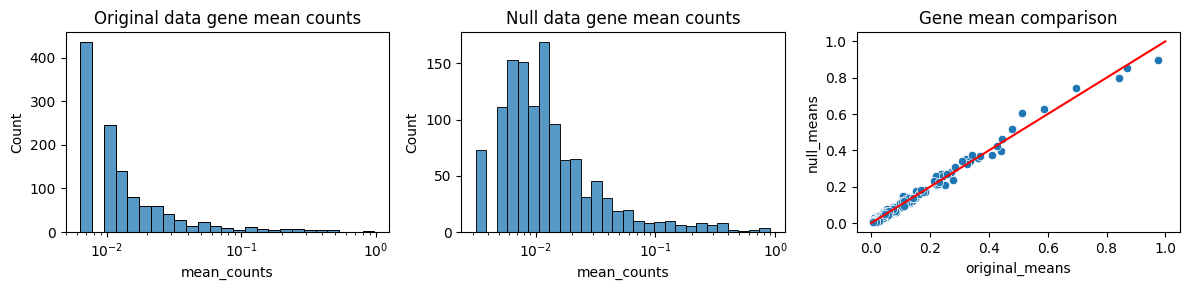

SignificanceResult(statistic=0.8045580723308888, pvalue=1.8445965716724956e-277)


In [12]:
fig, ax = plt.subplots(1, 3, figsize=(12,3))
sns.histplot(data_gene_nonzero.var, x="mean_counts", ax=ax[0], log_scale=True)
ax[0].set_title("Original data gene mean counts")
sns.histplot(data_null_gen.var, x="mean_counts", ax=ax[1], log_scale=True)
ax[1].set_title("Null data gene mean counts")

mean_df_opt = pd.DataFrame({"original_means": data_gene_nonzero.var["mean_counts"], "null_means": data_null_gen.var["mean_counts"]})
sns.scatterplot(mean_df_opt, y="null_means", x="original_means", ax=ax[2])
ax[2].plot([0, np.ceil(np.max(data_gene_nonzero.var["mean_counts"]))], [0, np.ceil(np.max(data_gene_nonzero.var["mean_counts"]))], color="red")
ax[2].set_title("Gene mean comparison")
plt.tight_layout()
plt.show()

print(spearmanr(mean_df_opt["original_means"], mean_df_opt["null_means"]))

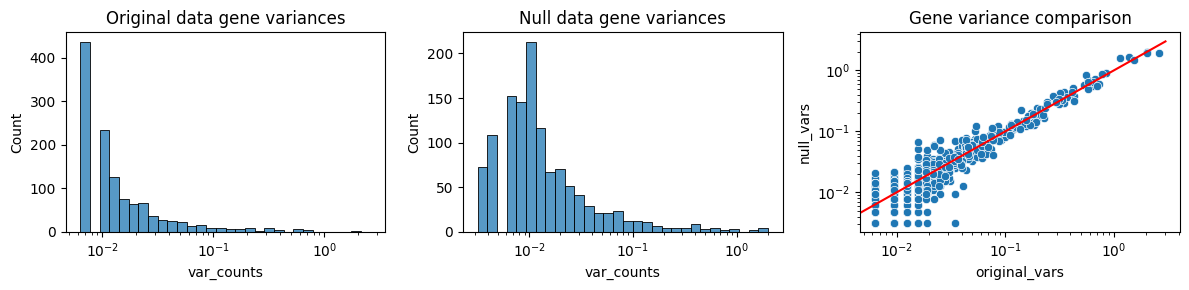

SignificanceResult(statistic=0.7805543485814682, pvalue=2.1435731441419277e-250)
[[1.         0.98020998]
 [0.98020998 1.        ]]


In [13]:
fig, ax = plt.subplots(1, 3, figsize=(12,3))
sns.histplot(data_gene_nonzero.var, x="var_counts", ax=ax[0], log_scale=True)
ax[0].set_title("Original data gene variances")
sns.histplot(data_null_gen.var, x="var_counts", ax=ax[1], log_scale=True)
ax[1].set_title("Null data gene variances")

var_df_opt = pd.DataFrame({"original_vars": data_gene_nonzero.var["var_counts"], "null_vars": data_null_gen.var["var_counts"]})
var_df_opt["ratio"] = var_df_opt["null_vars"] / var_df_opt["original_vars"]
var_df_opt["diff"] = var_df_opt["null_vars"] - var_df_opt["original_vars"]

g = sns.scatterplot(var_df_opt, y="null_vars", x="original_vars", ax=ax[2])

g.set(xscale="log", yscale="log")
ax[2].plot([0, np.ceil(np.max(data_gene_nonzero.var["var_counts"]))], [0, np.ceil(np.max(data_gene_nonzero.var["var_counts"]))], color="red")
ax[2].set_title("Gene variance comparison")
plt.tight_layout()
plt.show()

print(spearmanr(var_df_opt["original_vars"], var_df_opt["null_vars"]))
print(np.corrcoef(var_df_opt["original_vars"], var_df_opt["null_vars"]))

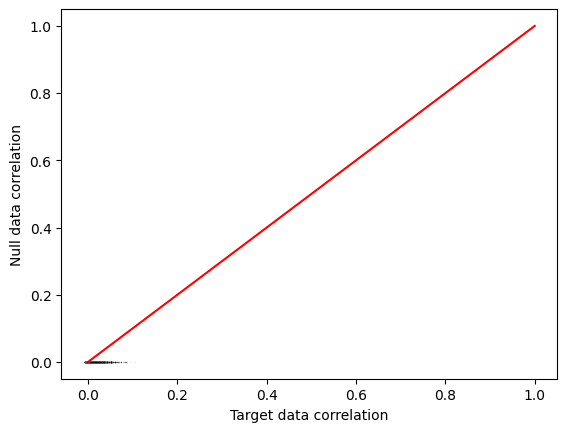

In [14]:
cor_shrink = cd.schaefer_strimmer(data_gene_nonzero.layers["counts"].toarray(), use_corr=True)
cor_shrink = pd.DataFrame(cor_shrink, index=data_gene_nonzero.var_names, columns=data_gene_nonzero.var_names)

cor_gen_shrink = cd.schaefer_strimmer(data_null_gen.X, use_corr=True)
cor_gen_shrink = pd.DataFrame(cor_gen_shrink, index=data_gene_nonzero.var_names, columns=data_gene_nonzero.var_names)

# Plot only 100.000 randomly sampled correlations instaed of ~30M
rng = np.random.default_rng(1234)
all_cors = pd.DataFrame({"cor_shrink": cor_shrink.values.flatten(), "cor_gen_shrink": cor_gen_shrink.values.flatten()})

ids = rng.choice(len(all_cors), 100000, replace=False)
all_cors_subset = all_cors.loc[ids]

sns.scatterplot(all_cors_subset[all_cors_subset['cor_shrink'] < 0.99], x="cor_shrink", y="cor_gen_shrink", s=1,
                color="black", alpha=0.1)
plt.plot([0, np.ceil(np.max(all_cors_subset['cor_shrink']))], [0, np.ceil(np.max(all_cors_subset['cor_shrink']))],
         color="red")
plt.xlabel("Target data correlation")
plt.ylabel("Null data correlation")

plt.show()

### Process null data

In [15]:
sc.pp.calculate_qc_metrics(data_null_gen)
data_null_gen.var["var_counts"] = np.asarray(np.var(data_null_gen.X, axis=0)).squeeze()
data_null_gen.var["mean_counts"] = np.asarray(np.mean(data_null_gen.X, axis=0)).squeeze()

In [16]:
importlib.reload(nb)
nb.estimate_overdisp_nb(data_null_gen, flavor="sctransform")
data_null_gen.layers["counts"] = data_null_gen.X.copy()

k_opt = data_gene.uns["BacSC_params"]["k_opt"]
n_neighbors_opt = data_gene.uns["BacSC_params"]["n_neighbors_opt"]
min_dist_opt = data_gene.uns["BacSC_params"]["min_dist_opt"]
res_opt = data_gene.uns["BacSC_params"]["res_opt"]
print(n_neighbors_opt)

sc.pp.calculate_qc_metrics(data_null_gen, var_type="genes", percent_top=None, log1p=True, inplace=True)
sc.pp.normalize_total(data_null_gen, target_sum=None, layer=None)
data_null_gen.X = sps.csr_matrix(np.log(data_null_gen.X + np.array(data_null_gen.var["nb_overdisp"] / 4)))
data_null_gen.layers["vst_counts"] = data_null_gen.X.copy()
sc.pp.scale(data_null_gen, max_value=10, zero_center=True)
data_null_gen.X[np.isnan(data_null_gen.X)] = 0
sc.tl.pca(data_null_gen, svd_solver='arpack')
sc.pp.neighbors(data_null_gen, n_neighbors=n_neighbors_opt, n_pcs=k_opt)
sc.tl.umap(data_null_gen, neighbors_key="neighbors", min_dist=min_dist_opt, spread=1)


10


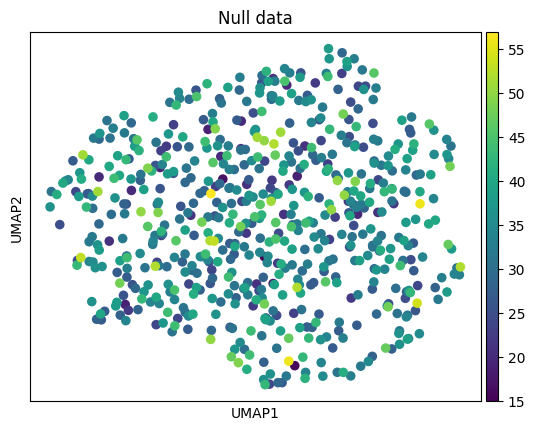

In [17]:
sc.pl.umap(data_null_gen, color="total_counts", alpha=1, cmap="viridis", title="Null data")
plt.show()


In [18]:
data_null_gen.write(data_path + "/null_data_klebsiella_4species.h5ad")

In [19]:
data_null_gen = sc.read_h5ad(data_path + "/null_data_klebsiella_4species.h5ad")
data_gene_nonzero = data_gene[:, data_null_gen.var_names].copy()

In [20]:
n_splits = 1
rng = np.random.default_rng(2345)
seeds = rng.choice(1000, n_splits)
null_pvals_dict = {}
min_pvals_null = []
c = 0
res_start = 0.01
res_step = 0.01

for s in seeds:
    res2 = res_start
    twoclust = False
    nclust = 1
    was_greater = False
    max_res_1_cluster = 0
    
    while twoclust is False:
        if nclust < 2:
            if res2 > max_res_1_cluster:
                max_res_1_cluster = res2
            elif max_res_1_cluster > 0: 
                res_step = res_step/2
            if was_greater:
                res2 += res_step
            else:
                res2 += 0.05
        else:
            was_greater = True
            min_res_2plus_clusters = res2
            res2 -= res_step
        res2 = np.round(res2, 5)
        sc.tl.leiden(data_null_gen, resolution=res2, key_added=f"leiden_{c}", random_state=s)
        nclust = len(data_null_gen.obs[f"leiden_{c}"].unique())
        if nclust == 2:
            twoclust = True
        print(f"resolution: {res2}, clusters: {nclust}, step: {res_step}")
            
    X_null_gen_0 = data_null_gen.X[data_null_gen.obs[f"leiden_{c}"] == "0"]
    X_null_gen_1 = data_null_gen.X[data_null_gen.obs[f"leiden_{c}"] != "0"]
    null_pvals = ranksums(X_null_gen_0, X_null_gen_1, alternative="two-sided").pvalue
    null_pvals_dict[c] = null_pvals

    clusters = data_gene.obs["leiden_opt"].unique()
            
    min_pvals_null.append(np.min(null_pvals))
            
    print(f"split {c+1}/{n_splits} - Resolution {res2}")

    res_start = res2 - 0.05
    c += 1
    
best_split = np.where(min_pvals_null == np.max(min_pvals_null))[0][0]
print(best_split)
print(min_pvals_null[best_split])

resolution: 0.06, clusters: 1, step: 0.01
resolution: 0.11, clusters: 1, step: 0.01
resolution: 0.16, clusters: 2, step: 0.01
split 1/1 - Resolution 0.16
0
0.0029978052825982305


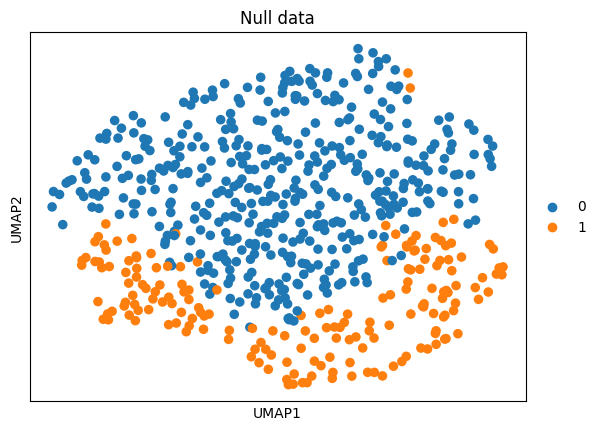

In [21]:
sc.pl.umap(data_null_gen, color=f"leiden_{best_split}", alpha=1, cmap="viridis", title="Null data")
plt.show()

In [23]:
data_null_gen.obs["leiden_best"] = data_null_gen.obs[f"leiden_{best_split}"]

data_null_gen.write(data_path + "/null_data_klebsiella_4species.h5ad")

In [24]:
importlib.reload(cd)
clusters = data_gene.obs["leiden_opt"].unique()
DEs_log_gen = {}
pvals_log_gen = {}
fdr = 0.05
rng = np.random.default_rng(1234)

for c in clusters:
    
    X_data_0 = data_gene_nonzero.X[data_gene_nonzero.obs["leiden_opt"] == c].copy()
    X_data_1 = data_gene_nonzero.X[data_gene_nonzero.obs["leiden_opt"] != c].copy()
    
    n_cells_0 = X_data_0.shape[0]
    n_cells_1 = X_data_1.shape[0]
    
    X_null_gen_0 = data_null_gen.X[data_null_gen.obs[f"leiden_best"] != "0"]
    X_null_gen_0 = X_null_gen_0[rng.integers(X_null_gen_0.shape[0], size=n_cells_0),:]
    X_null_gen_1 = data_null_gen.X[data_null_gen.obs[f"leiden_best"] == "0"]
    X_null_gen_1 = X_null_gen_1[rng.integers(X_null_gen_1.shape[0], size=n_cells_1),:]
    null_pvals = ranksums(X_null_gen_0, X_null_gen_1, alternative="two-sided").pvalue
    
    pvals_data = ranksums(X_data_0, X_data_1, alternative="two-sided").pvalue
    p_data = pd.DataFrame({"pval_data": pvals_data}, index=data_gene_nonzero.var.index)
    pval_null_gen = pd.DataFrame({"pval_null": null_pvals}, index=data_null_gen.var.index)
    
    DE_TU, pval_TU = cd.call_de(p_data, pval_null_gen, FDR=fdr, correct=False, nlog=True)
    data_gene_nonzero.var[f"pval_cluster_{c}_gen"] = pval_TU["pval_data"]
    data_gene_nonzero.var[f"q_cluster_{c}_gen"] = pval_TU["q"]
    data_gene_nonzero.var[f"DE_cluster_{c}_gen"] = (data_gene_nonzero.var[f"q_cluster_{c}_gen"] < fdr)
    
    DEs_log_gen[c] = DE_TU
    pvals_log_gen[c] = pval_TU
    print(f"Cluster {c} - DE genes: {len(DEs_log_gen[c])}; Minimum q value: {np.min(pvals_log_gen[c]['q'])}")

Cluster 0 - DE genes: 0; Minimum q value: 0.07142857142857142
Cluster 1 - DE genes: 62; Minimum q value: 0.0196078431372549
Cluster 3 - DE genes: 0; Minimum q value: 0.3333333333333333
Cluster 2 - DE genes: 24; Minimum q value: 0.041666666666666664
Cluster 4 - DE genes: 0; Minimum q value: 0.0625


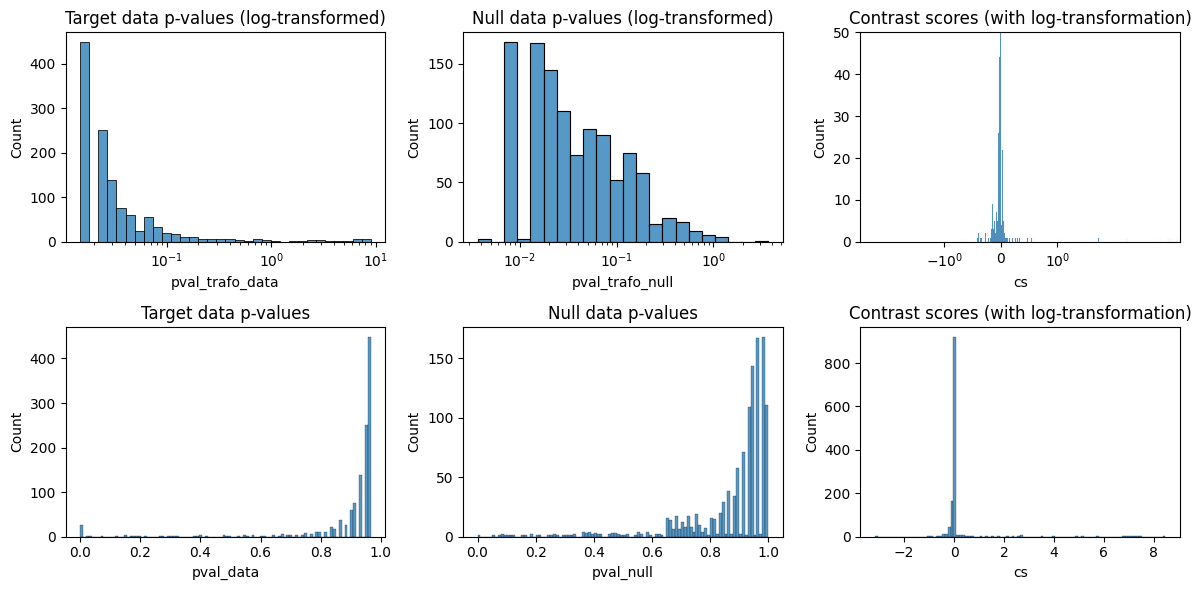

In [25]:
c = "4"

fig, ax = plt.subplots(2, 3, figsize=(12,6))
sns.histplot(pvals_log_gen[c], x="pval_trafo_data", ax=ax[0,0], log_scale=True)
ax[0,0].set_title("Target data p-values (log-transformed)")
sns.histplot(pvals_log_gen[c], x="pval_trafo_null", ax=ax[0,1], log_scale=True)
ax[0,1].set_title("Null data p-values (log-transformed)")

sns.histplot(pvals_log_gen[c], x="cs", ax=ax[0,2])
ax[0,2].set_title("Contrast scores (with log-transformation)")
ax[0,2].set(xscale="symlog", ylim=(0, 50))

sns.histplot(pvals_log_gen[c], x="pval_data", ax=ax[1,0], bins=100)
ax[1,0].set_title("Target data p-values")
sns.histplot(pvals_log_gen[c], x="pval_null", ax=ax[1,1], bins=100)
ax[1,1].set_title("Null data p-values")

sns.histplot(pvals_log_gen[c], x="cs", ax=ax[1,2], bins=100)
ax[1,2].set_title("Contrast scores (with log-transformation)")


plt.tight_layout()
plt.show()

In [26]:
for c in clusters:
    print(f"cluster {c}")
    print(pvals_log_gen[c]["q"].value_counts().sort_index())
    print("")

cluster 0
0.071429     14
0.111111     13
0.121951     14
0.148936      6
0.166667      1
0.169811      5
0.200000      7
0.203125      4
0.212121      2
0.264706      2
0.304348      1
0.342857      1
0.364865      4
0.373333      1
0.387500      5
0.407407      1
0.443182      7
0.466667      2
0.494505      1
0.500000      3
0.504950      7
0.519608      1
0.552381      3
0.566038      1
0.598131      1
0.603306     14
0.622951      1
0.626016      1
0.653226      1
0.671875      4
0.705426      1
0.753846      1
0.757322    348
0.758221     39
0.838095      8
0.842991     10
0.846863      7
0.848987      1
0.849541      2
0.849817      1
0.851986      8
0.859712      2
0.863105     43
0.868333      1
0.868552      1
0.868852      9
0.870915      2
0.871126      1
0.872990      9
1.000000    596
Name: q, dtype: int64

cluster 1
0.019608     51
0.034483      7
0.048387      4
0.051948     15
0.061728      4
           ... 
0.654232      2
0.656160      1
0.665714      2
0.674750     

In [27]:
pvals_log_gen["3"]

,pval_data,pval_null,pval_trafo_data,pval_trafo_null,cs,q
2578228320,0.019271,0.490801,1.715099,0.309095,1.406004,0.333333
2578228324,0.040122,0.948019,1.396623,0.023183,1.373440,0.333333
2578225898,0.098695,0.975789,1.005705,0.010644,0.995061,0.333333
2578225900,0.088373,0.797734,1.053681,0.098142,0.955539,0.333333
2578227039,0.090493,0.812523,1.043385,0.090164,0.953221,0.333333
...,...,...,...,...,...,...
2578225910,0.496477,0.125784,0.304101,0.900375,-0.596274,1.000000
2578225168,0.953390,0.193810,0.020729,0.712623,-0.691894,1.000000
2578224641,0.988341,0.186211,0.005093,0.729994,-0.724901,1.000000
2578227954,0.704001,0.122757,0.152427,0.910955,-0.758528,1.000000


In [28]:
data_gene_nonzero.uns["ClusterDE_results"] = pvals_log_gen

data_gene_nonzero.uns["ClusterDE_results"]['params'] = {'groupby': 'leiden_opt',
  'reference': 'rest',
  'use_raw': False,
  'layer': None,
}

In [29]:
data_gene_nonzero.write(data_path + "/klebsiella_4species_data_processed_cluster.h5ad")

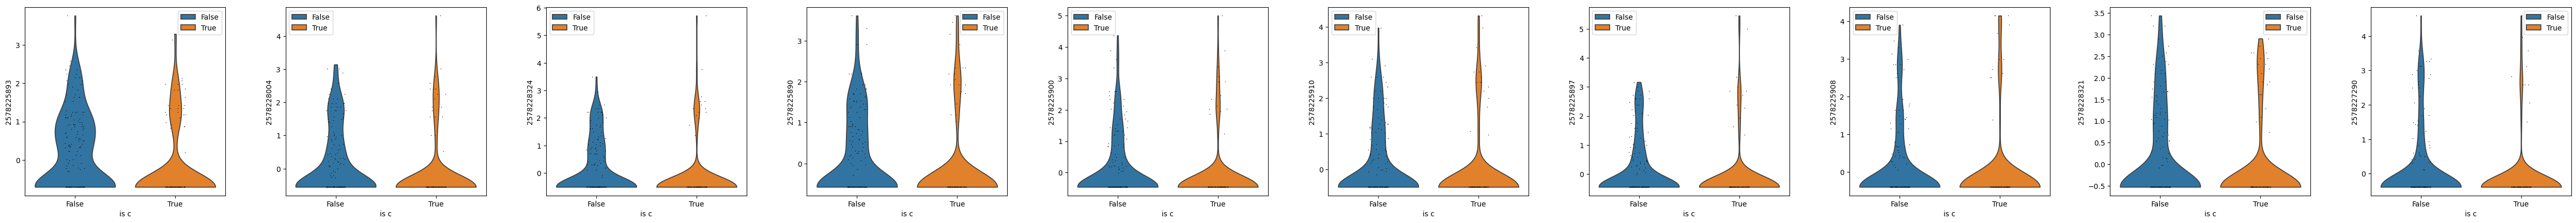

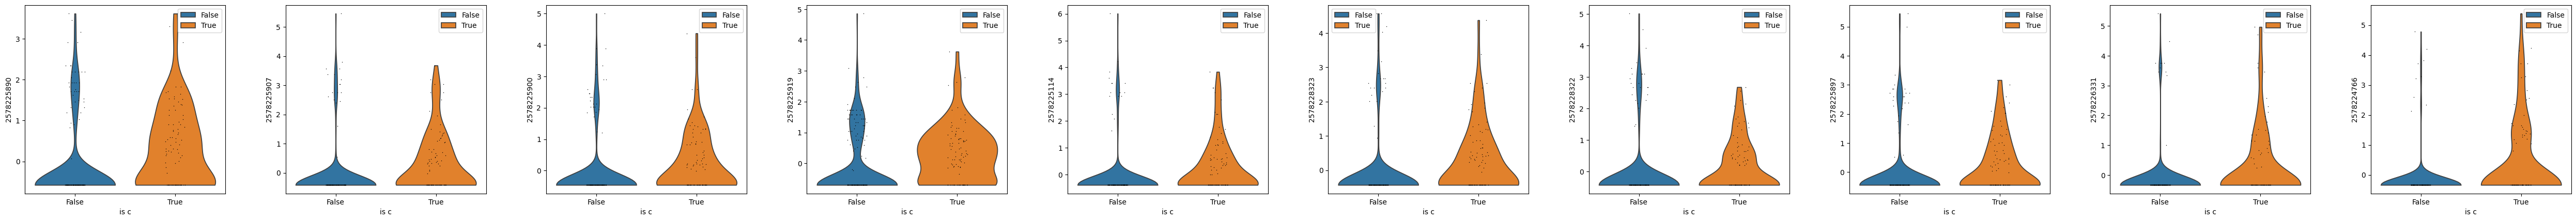

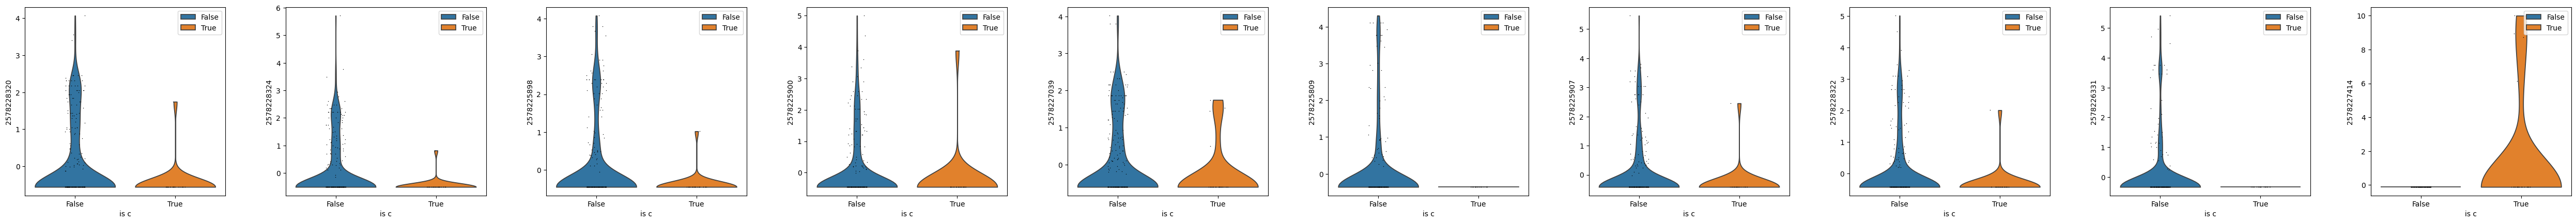

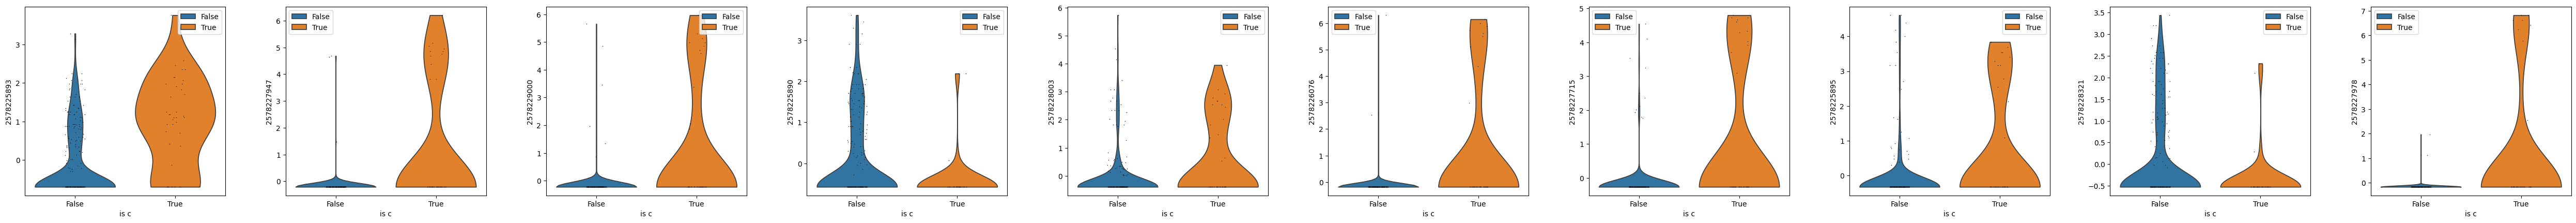

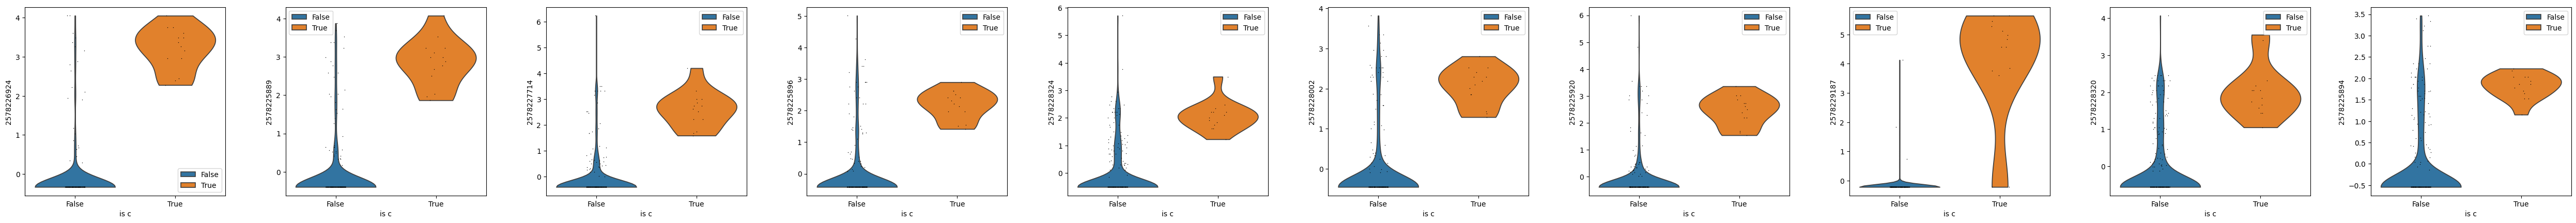

In [30]:
for c in clusters:
    plot_genes = data_gene_nonzero.uns["ClusterDE_results"][c].iloc[:10,:].index.tolist()
    data_gene_nonzero.obs["is_c"] = pd.Categorical([x==c for x in data_gene_nonzero.obs["leiden_opt"]])
    with plt.rc_context({"figure.figsize": (5, 5)}):
        sc.pl.violin(data_gene_nonzero, keys=plot_genes, groupby="is_c", multi_panel=True)

In [31]:
data_gene.var

,n_cells_by_counts,mean_counts,log1p_mean_counts,pct_dropout_by_counts,total_counts,log1p_total_counts,n_cells,var_counts,is_scd_outlier,nb_overdisp,...,product_accession,name,symbol,gene_mean,gene_var,mean_var_diff,gene_dist,est_mean,est_overdisp,est_zero_inflation
2578223750,5,0.015873,0.015748,98.412698,5.0,1.791759,5,0.015621,False,0.672014,...,NaN,NaN,NaN,0.015873,0.015621,0.000252,poi,0.015907,inf,0.002565
2578223780,2,0.006349,0.006329,99.365079,2.0,1.098612,2,0.006309,False,0.360850,...,NaN,NaN,NaN,0.006349,0.006309,0.000040,poi,0.006455,inf,0.017704
2578223790,3,0.009524,0.009479,99.047619,3.0,1.386294,3,0.009433,False,0.465988,...,NaN,NaN,NaN,0.009524,0.009433,0.000091,poi,0.010585,inf,0.100562
2578223794,2,0.006349,0.006329,99.365079,2.0,1.098612,2,0.006309,False,0.360850,...,NaN,NaN,NaN,0.006349,0.006309,0.000040,poi,0.006455,inf,0.017704
2578223796,3,0.009524,0.009479,99.047619,3.0,1.386294,3,0.009433,False,0.465988,...,NaN,NaN,NaN,0.009524,0.009433,0.000091,poi,0.010585,inf,0.100562
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2578229255,3,0.009524,0.009479,99.047619,3.0,1.386294,3,0.009433,False,0.465988,...,NaN,NaN,NaN,0.009524,0.009433,0.000091,poi,0.010585,inf,0.100562
2578229258,5,0.015873,0.015748,98.412698,5.0,1.791759,5,0.015621,False,0.672014,...,NaN,NaN,NaN,0.015873,0.015621,0.000252,poi,0.015907,inf,0.002565
2578229259,3,0.009524,0.009479,99.047619,3.0,1.386294,3,0.009433,False,0.465988,...,NaN,NaN,NaN,0.009524,0.009433,0.000091,poi,0.010585,inf,0.100562
2578229260,5,0.015873,0.015748,98.412698,5.0,1.791759,5,0.015621,False,0.672014,...,NaN,NaN,NaN,0.015873,0.015621,0.000252,poi,0.015907,inf,0.002565


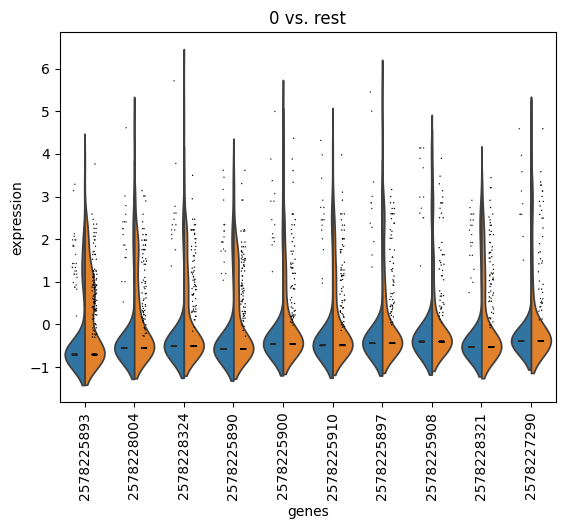

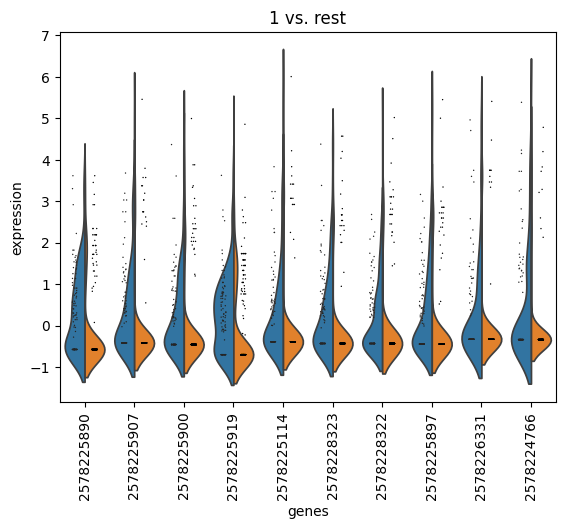

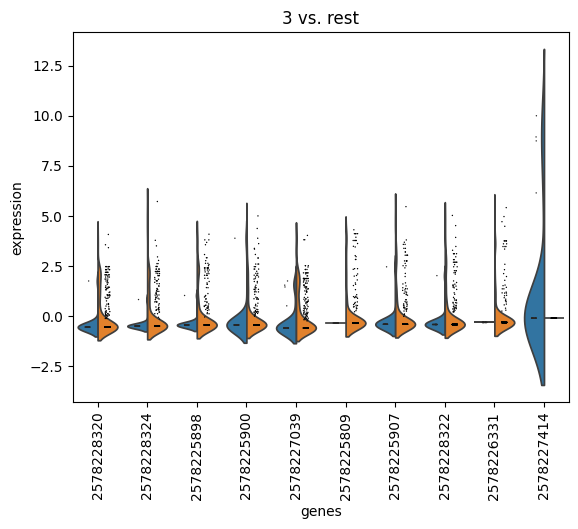

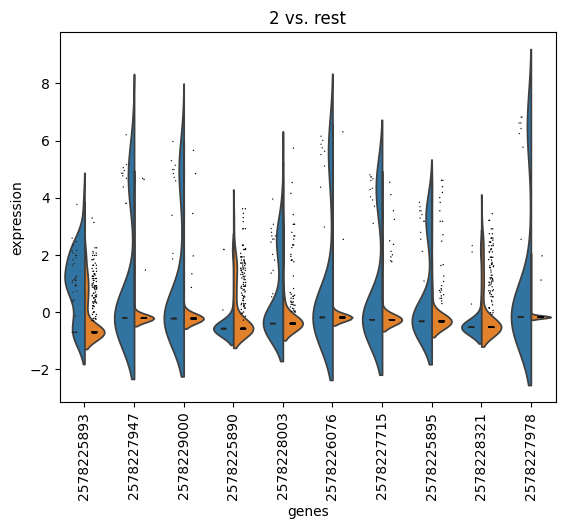

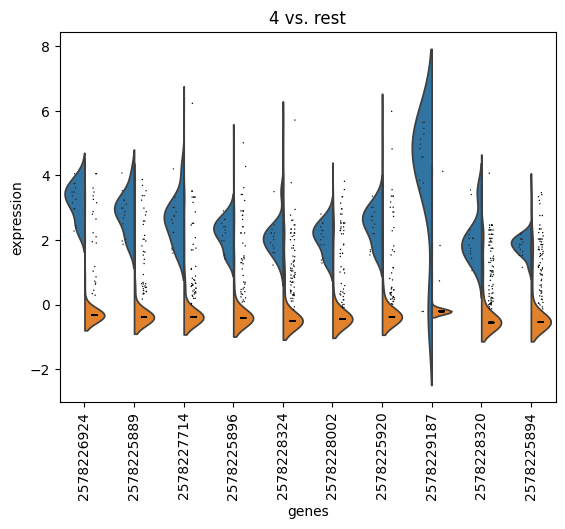

In [32]:
n_genes = 10
for c in clusters:
    plot_genes = data_gene_nonzero.uns["ClusterDE_results"][c].iloc[:n_genes,:].index.tolist()
    sc.pl.rank_genes_groups_violin(data_gene_nonzero, gene_names=plot_genes, key="ClusterDE_results", groups=c)

In [33]:
all_marker_genes = []
for c in clusters:
    plot_genes = data_gene_nonzero.uns["ClusterDE_results"][c].iloc[:n_genes,:].index.tolist()
    all_marker_genes += plot_genes
    print(f"Cluster {c}")
    print(data_gene.var.loc[plot_genes, ["locus_tag", "name", "symbol"]])

Cluster 0
            locus_tag  name  symbol
2578225893        NaN   NaN     NaN
2578228004        NaN   NaN     NaN
2578228324        NaN   NaN     NaN
2578225890        NaN   NaN     NaN
2578225900        NaN   NaN     NaN
2578225910        NaN   NaN     NaN
2578225897        NaN   NaN     NaN
2578225908        NaN   NaN     NaN
2578228321        NaN   NaN     NaN
2578227290        NaN   NaN     NaN
Cluster 1
            locus_tag  name  symbol
2578225890        NaN   NaN     NaN
2578225907        NaN   NaN     NaN
2578225900        NaN   NaN     NaN
2578225919        NaN   NaN     NaN
2578225114        NaN   NaN     NaN
2578228323        NaN   NaN     NaN
2578228322        NaN   NaN     NaN
2578225897        NaN   NaN     NaN
2578226331        NaN   NaN     NaN
2578224766        NaN   NaN     NaN
Cluster 3
            locus_tag  name  symbol
2578228320        NaN   NaN     NaN
2578228324        NaN   NaN     NaN
2578225898        NaN   NaN     NaN
2578225900        NaN   NaN     Na

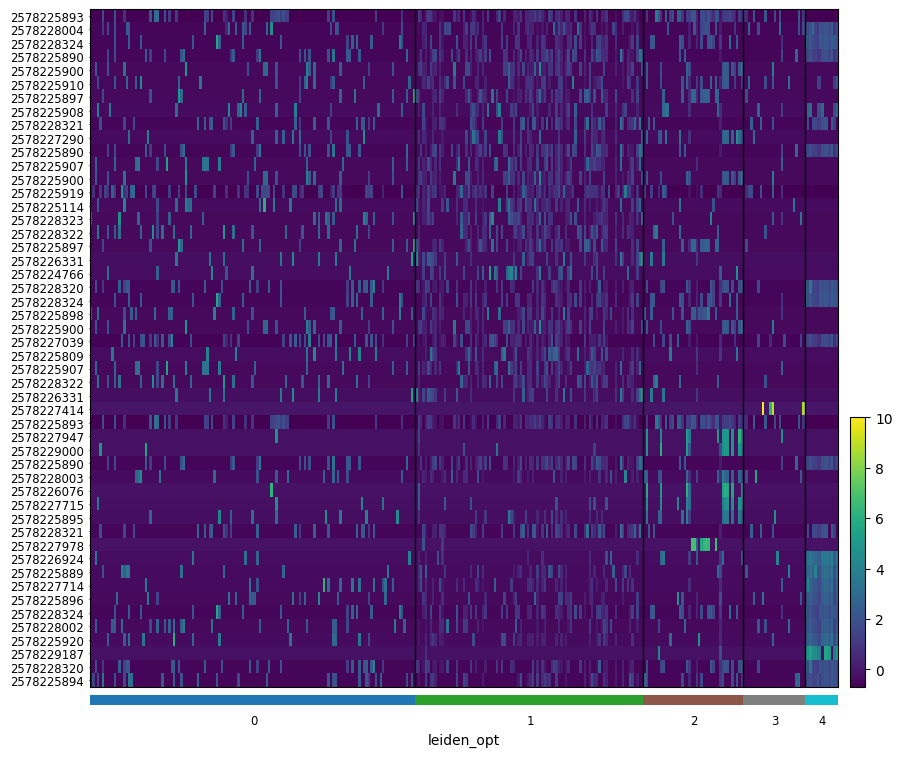

In [34]:
sc.pl.heatmap(data_gene_nonzero, all_marker_genes, groupby='leiden_opt', swap_axes=True, show_gene_labels=True)